# Bert-large with classweights in loss - best model on test set
### Inference optimization at the end of notebook

In [1]:
from datasets import load_dataset

import pandas as pd
import matplotlib.pyplot as plt



In [2]:

# Load the dataset
dataset = load_dataset('dair-ai/emotion')

# Convert to pandas dataframe
train_data = pd.DataFrame(dataset['train'])
val_data = pd.DataFrame(dataset['validation'])
test_data = pd.DataFrame(dataset['test'])

print(train_data.head())
print(test_data.head())

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0


In [3]:
train_data['label'].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [4]:
train_data = train_data.drop_duplicates(subset='text')
train_data = train_data.reset_index(drop=True)

In [5]:
train_data.isna().values.any()

False

In [6]:
train_data['len'] = [len(text.split()) for text in train_data['text']]

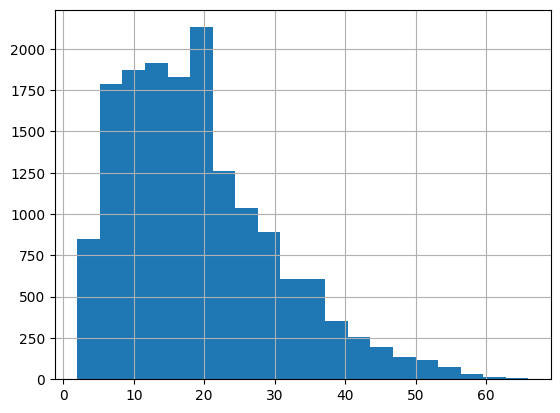

In [7]:
train_data['len'].hist(bins=20)
plt.show()

# Training

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score, classification_report
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import StepLR




import torch
import torch.nn as nn
import numpy as np


In [9]:
%%capture
tokenizer = BertTokenizer.from_pretrained("bert-large-cased")
model = BertForSequenceClassification.from_pretrained("bert-large-cased", num_labels=6)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

In [10]:
import torch
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [11]:
train_dataset = CustomDataset(train_data['text'], train_data['label'])
val_dataset = CustomDataset(val_data['text'], val_data['label'])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
import numpy as np
class_counts = np.bincount(train_data['label'])

# Calculate class weights
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float) 

print(class_weights)

tensor([0.0002, 0.0002, 0.0008, 0.0005, 0.0005, 0.0018])


In [13]:
device = torch.device('cuda:3')
# device = torch.device('cpu')
model.to(device)

# for param in model.parameters():
#     param.requires_grad = False

# # Then, enable gradient computations for the classifier only
# for param in model.classifier.parameters():
#     param.requires_grad = True
    
    
optimizer = torch.optim.Adam([
    {'params': model.bert.parameters(), 'lr': 1e-5},
    {'params': model.dropout.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
])
# lr_lambda = lambda epoch: 1e-3 if epoch > 5 else 1e-3

# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

epochs = 15
best_score = 0

Epoch:  11
62


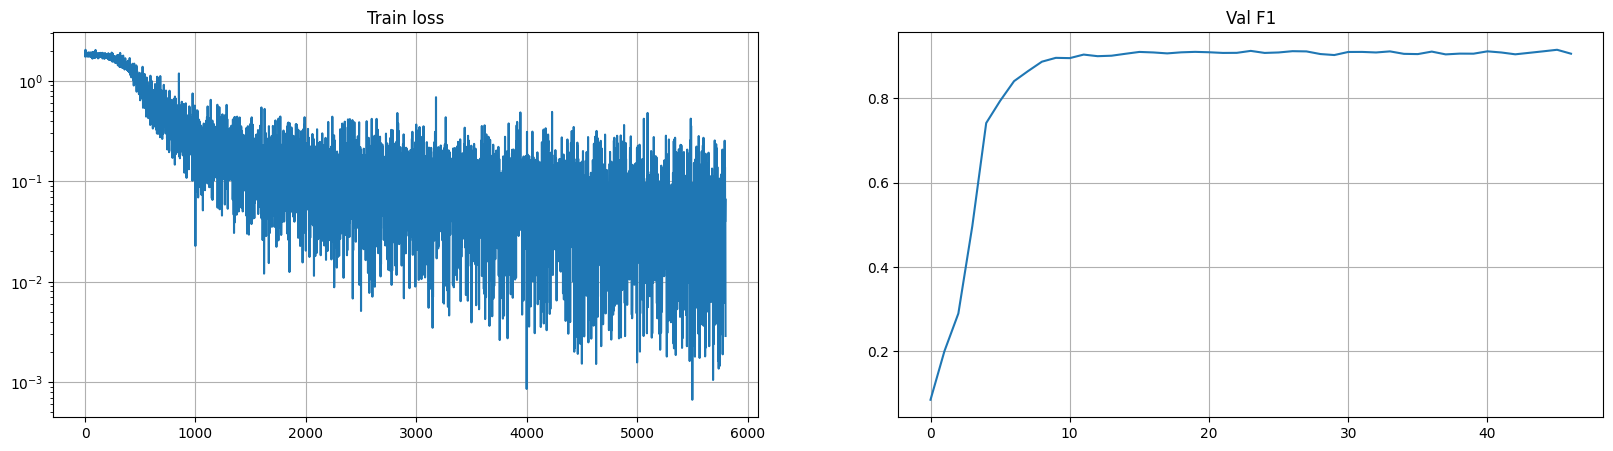

  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
train_loss = []
val_metrics = []


for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):
        model.train()
        inputs = tokenizer(list(batch[0]), 
                           max_length=512, 
                           truncation=True,
                           padding='longest',
                           return_tensors='pt').to(device)
        logits = model(**inputs).logits
        loss = nn.CrossEntropyLoss(weight=class_weights.to(device))(logits, batch[1].to(device))
        loss.backward()
        if i % 5 == 0:
            optimizer.step()
            optimizer.zero_grad()
    #         scheduler.step()
        
        train_loss.append(loss.item())
        
        if i % 100 == 0 and i != 0:
            model.eval()
            labels = np.array([])
            preds = np.array([])
            for i, batch in enumerate(tqdm(val_dataloader)):
                inputs = tokenizer(list(batch[0]), 
                                   max_length=512, 
                                   truncation=True,
                                   padding='longest',
                                   return_tensors='pt').to(device)
                with torch.no_grad():
                    logits = model(**inputs).logits
                preds = np.append(preds,
                                torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
                labels = np.append(labels, batch[1].numpy())
                
            score = f1_score(preds, labels, average='macro')
            if score > best_score:
                model.save_pretrained('bert-tiny-emotions')
                tokenizer.save_pretrained('bert-tiny-emotions')
                best_score = score
                
            val_metrics.append(score)

            #print plots
            clear_output()
            print('Epoch: ', epoch)
            print(i)
            plt.figure(figsize=(20,5))
            plt.subplot(121)
            plt.semilogy(train_loss)
            plt.title('Train loss')
            plt.grid(True)
            plt.subplot(122)
            plt.plot(val_metrics)
            plt.title('Val F1')
            plt.grid(True)
            plt.show()
                
                
                    

                
        

# Inference

In [16]:
#load best model
model = BertForSequenceClassification.from_pretrained('bert-tiny-emotions')
model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

## Validation data

In [54]:
#inference
labels = np.array([])
preds = np.array([])
for i, batch in enumerate(tqdm(val_dataloader)):
    inputs = tokenizer(list(batch[0]), 
                       max_length=512, 
                       truncation=True,
                       padding='longest',
                       return_tensors='pt').to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    preds = np.append(preds,
                    torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
    labels = np.append(labels, batch[1].numpy())

f1_score(preds, labels, average='macro')

  0%|          | 0/63 [00:00<?, ?it/s]

0.9152769747821877

In [18]:
names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(preds, list(labels), output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
sadness,0.960000,0.961749,0.960874,549.000
joy,0.936080,0.967695,0.951625,681.000
love,0.921348,0.863158,0.891304,190.000
anger,0.934545,0.948339,0.941392,271.000
fear,0.943396,0.851064,0.894855,235.000
surprise,0.814815,0.891892,0.851613,74.000
accuracy,0.937000,0.937000,0.937000,0.937
macro avg,0.918364,0.913983,0.915277,2000.000
weighted avg,0.937411,0.937000,0.936676,2000.000


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(list(labels), preds )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
                              )
disp.plot()

plt.show()

## Test data

In [19]:
test_dataset = CustomDataset(test_data['text'], test_data['label'])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [20]:
%%time
labels = np.array([])
preds = np.array([])
for i, batch in enumerate(tqdm(test_dataloader)):
    inputs = tokenizer(list(batch[0]), 
                       max_length=512, 
                       truncation=True,
                       padding='longest',
                       return_tensors='pt').to(device)
    with torch.no_grad():
        preds = np.append(preds,
                        torch.argmax(model(**inputs).logits, axis=1).cpu().numpy())
        labels = np.append(labels, batch[1].numpy())

f1_score(preds, labels, average='macro')

  0%|          | 0/63 [00:00<?, ?it/s]

CPU times: user 7.49 s, sys: 24.4 ms, total: 7.51 s
Wall time: 7.52 s


0.8886563911312604

In [21]:

names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
report = classification_report(preds, list(labels), output_dict=True, target_names=names.values())#, target_names=[high_lbls]
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
sadness,0.962134,0.962134,0.962134,581.0000
joy,0.933813,0.970105,0.951613,669.0000
love,0.905660,0.804469,0.852071,179.0000
anger,0.912727,0.922794,0.917733,272.0000
fear,0.924107,0.858921,0.890323,241.0000
surprise,0.712121,0.810345,0.758065,58.0000
accuracy,0.928500,0.928500,0.928500,0.9285
macro avg,0.891761,0.888128,0.888656,2000.0000
weighted avg,0.929054,0.928500,0.928154,2000.0000


# Optimization

## ONNX

In [55]:
model.to('cpu')
#get input example
dummy_model_input = tokenizer("This is a sample", return_tensors="pt")

# export
torch.onnx.export(
    model, 
    tuple(dummy_model_input.values()),
    f="bert_large.onnx",  
    input_names=['input_ids', 'attention_mask', 'token_type_ids'], 
    output_names=['logits'], 
    dynamic_axes={'input_ids': {0: 'batch_size', 1: 'sequence'}, 
                  'attention_mask': {0: 'batch_size', 1: 'sequence'}, 
                  'token_type_ids': {0: 'batch_size', 1: 'sequence'}, 
                  'logits': {0: 'batch_size', 1: 'sequence'}}, 
    do_constant_folding=True, 
    opset_version=13, 
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [40]:
# check for correctness
from onnxruntime import InferenceSession, SessionOptions, get_all_providers
from onnxruntime.quantization import quantize, QuantType

# Load the ONNX model
sess = InferenceSession("bert_large.onnx", providers=['CPUExecutionProvider'])

inputs = tokenizer(next(iter(train_dataloader))[0], padding=True, truncation=True, max_length=512, return_tensors='np')

input_names = ['input_ids', 'attention_mask','token_type_ids']
inputs_onnx = {k: inputs[k] for k in input_names}

# Load the quantized ONNX model

# Perform inference
outputs = sess.run(None, inputs_onnx)

# The output is a list, you can access the logits like this:
logits = outputs[0]

In [43]:
np.argmax(logits, axis=1)

array([0, 1, 0, 1, 1, 4, 3, 3, 1, 0, 4, 3, 1, 0, 1, 0, 1, 0, 1, 2, 4, 1,
       0, 1, 4, 1, 5, 1, 3, 4, 4, 4])

## Quantization ONNX model

In [44]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = 'bert_large.onnx'
model_quant = 'bert_large.quant.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant)

Ignore MatMul due to non constant B: /[/bert/encoder/layer.0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.3/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.4/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.4/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.5/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.5/atten

In [88]:

from onnxruntime import InferenceSession, SessionOptions, get_all_providers
from onnxruntime.quantization import quantize, QuantType

# Load the ONNX model
sess = InferenceSession("bert_large.quant.onnx", providers=['CPUExecutionProvider'])

inputs = tokenizer(next(iter(train_dataloader))[0], padding=True, truncation=True, max_length=512, return_tensors='np')

input_names = ['input_ids', 'attention_mask','token_type_ids']
inputs_onnx = {k: inputs[k] for k in input_names}

# Load the quantized ONNX model

# Perform inference
outputs = sess.run(None, inputs_onnx)

# The output is a list, you can access the logits like this:
logits = outputs[0]

In [89]:
#define the function to perdict classes for batch
def get_onnx_prediction(texts):
    
    inputs = tokenizer(texts, padding='longest', truncation=True, max_length=512, return_tensors='np')

    input_names = ['input_ids', 'attention_mask','token_type_ids']
    inputs_onnx = {k: inputs[k] for k in input_names}

    # Perform inference
    outputs = sess.run(None, inputs_onnx)

    # The output is a list, you can access the logits like this:
    logits = outputs[0]
    return np.argmax(logits, axis=1)

In [90]:
for batch in tqdm(val_dataloader):
    labels = np.array([])
    preds = np.array([])
    
    preds = np.append(preds,
                        get_onnx_prediction(batch[0]))
    
    labels = np.append(labels, batch[1].numpy())
    

  0%|          | 0/63 [00:00<?, ?it/s]

In [91]:
#validation dataset score
f1_score(preds, labels, average='macro')

0.7904040404040406

In [93]:
for batch in tqdm(test_dataloader):
    labels = np.array([])
    preds = np.array([])
    
    preds = np.append(preds,
                        get_onnx_prediction(batch[0]))
    
    labels = np.append(labels, batch[1].numpy())
    

  0%|          | 0/63 [00:00<?, ?it/s]

In [94]:
#test dataset score
f1_score(preds, labels, average='macro')

0.7333333333333334